In [52]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize

import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.regularizers import l1, l2

early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=1, 
                             factor=0.8, min_lr=3e-4)
%matplotlib inline

In [2]:
def plot_history(network_history, metric='acc'):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history[metric])
    plt.plot(network_history.history['val_'+metric])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [3]:
x_train = pickle.load(open("x_train.obj","rb"))

x_test = pickle.load(open("x_test.obj","rb"))

y_train = pickle.load(open("y_train.obj","rb"))

In [4]:
x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

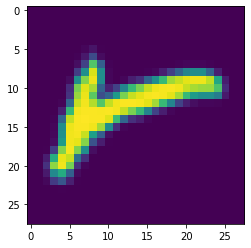

In [5]:
plt.imshow(x_train[0].reshape(28,28))

In [6]:
x_train.shape

(14000, 784)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [8]:
np.unique(y_train)
first_letter = min(y_train)
y_train = y_train - first_letter
y_val = y_val - first_letter

In [9]:
n_classes = len(np.unique(y_train))

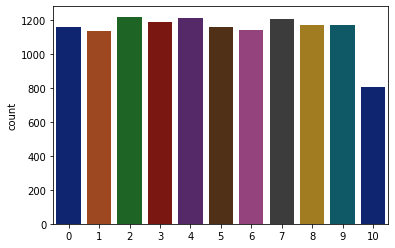

In [74]:
sns.countplot(y_train, palette='dark')
plt.show()

In [11]:
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [12]:
y_train_cat.shape #11 classi

(12600, 11)

In [59]:
input_layer = Input(shape=(x_train.shape[1],))
l = Dense(1024, input_shape=(x_train.shape[1],), activation='relu',
          kernel_regularizer=l2(0.01),
          activity_regularizer=l1(0.01))(input_layer)
l = Dropout(0.2)(l)
l = Dense(1024, activation='relu')(l)
l = Dropout(0.2)(l)
l = Dense(256, activation='relu')(l)
l = Dropout(0.2)(l)
output = Dense(n_classes, activation='softmax')(l)
model = Model(input_layer, output)
model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])

In [60]:
history = model.fit(x_train, y_train_cat, validation_data=(x_val, y_val_cat), 
                    epochs = 100, batch_size=1024, verbose=2,
                    callbacks=[lr_decay, early])

Train on 12600 samples, validate on 1400 samples
Epoch 1/100
12600/12600 - 3s - loss: 9.3769 - acc: 0.5093 - val_loss: 6.3134 - val_acc: 0.7171
Epoch 2/100
12600/12600 - 2s - loss: 4.9077 - acc: 0.7761 - val_loss: 3.3867 - val_acc: 0.8443
Epoch 3/100
12600/12600 - 2s - loss: 2.6663 - acc: 0.8721 - val_loss: 1.9250 - val_acc: 0.8914
Epoch 4/100
12600/12600 - 2s - loss: 1.5451 - acc: 0.9144 - val_loss: 1.1989 - val_acc: 0.9207
Epoch 5/100
12600/12600 - 2s - loss: 1.0004 - acc: 0.9341 - val_loss: 0.8470 - val_acc: 0.9364
Epoch 6/100
12600/12600 - 2s - loss: 0.7245 - acc: 0.9468 - val_loss: 0.6810 - val_acc: 0.9271
Epoch 7/100
12600/12600 - 2s - loss: 0.5865 - acc: 0.9494 - val_loss: 0.5861 - val_acc: 0.9307
Epoch 8/100
12600/12600 - 2s - loss: 0.5046 - acc: 0.9532 - val_loss: 0.5475 - val_acc: 0.9307
Epoch 9/100
12600/12600 - 2s - loss: 0.4506 - acc: 0.9571 - val_loss: 0.5290 - val_acc: 0.9343
Epoch 10/100
12600/12600 - 2s - loss: 0.4125 - acc: 0.9594 - val_loss: 0.4899 - val_acc: 0.9336


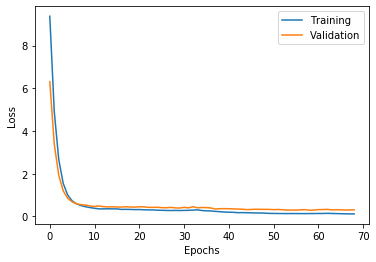

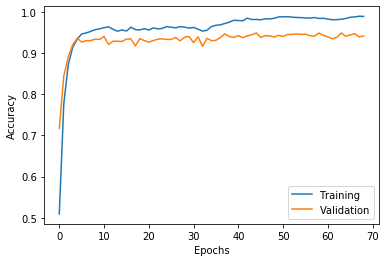

In [61]:
plot_history(history)

In [62]:
print(classification_report(y_val, model.predict(x_val).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       136
           1       0.93      0.96      0.94       129
           2       0.96      0.87      0.92       124
           3       0.97      0.96      0.97       137
           4       0.99      0.91      0.95       121
           5       0.89      0.97      0.93       134
           6       0.92      0.91      0.91       128
           7       0.96      0.95      0.95       116
           8       0.98      0.95      0.97       146
           9       0.91      0.95      0.93       146
          10       0.94      0.96      0.95        83

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



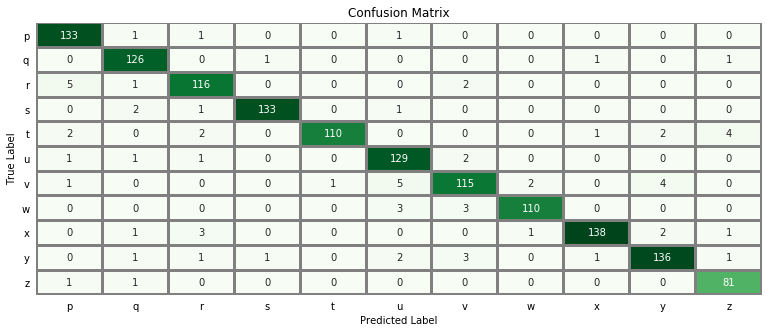

In [17]:
index = ['p','q','r','s','t','u','v','w','x','y','z']

plt.figure(figsize = (13,5))
cf_matrix = confusion_matrix(y_val, model.predict(x_val).argmax(axis=1))
ax = sns.heatmap(cf_matrix, xticklabels=index, yticklabels=index, cmap='Greens',
                 cbar=False, annot=True, fmt='d', linewidths=2, linecolor='gray')
ax.tick_params(left=False, bottom=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

In [35]:
input_layer = Input(shape=(x_train.shape[1],))
l = Dense(1024, input_shape=(x_train.shape[1],), activation='relu')(input_layer)
l = Dropout(0.2)(l)
l = Dense(1024, activation='relu')(l)
l = Dropout(0.2)(l)
l = Dense(256, activation='relu')(l)
l = Dropout(0.2)(l)
output = Dense(n_classes, activation='softmax')(l)
final_model = Model(input_layer, output)
final_model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])

In [36]:
history = final_model.fit(np.vstack((x_train, x_val)), np.vstack((y_train_cat, y_val_cat)), 
                          epochs = 30, batch_size=1024, verbose=1)

Epoch 1/30
14000/14000 [==============================] - 2s 166us/sample - loss: 1.2593 - acc: 0.6037
Epoch 2/30
14000/14000 [==============================] - 2s 135us/sample - loss: 0.5882 - acc: 0.8182
Epoch 3/30
14000/14000 [==============================] - 2s 142us/sample - loss: 0.3879 - acc: 0.8843
Epoch 4/30
14000/14000 [==============================] - 2s 139us/sample - loss: 0.2827 - acc: 0.9153
Epoch 5/30
14000/14000 [==============================] - 2s 137us/sample - loss: 0.2197 - acc: 0.9338
Epoch 6/30
14000/14000 [==============================] - 2s 136us/sample - loss: 0.1677 - acc: 0.9514
Epoch 7/30
14000/14000 [==============================] - 2s 139us/sample - loss: 0.1364 - acc: 0.9604
Epoch 8/30
14000/14000 [==============================] - 2s 137us/sample - loss: 0.1127 - acc: 0.9664
Epoch 9/30
14000/14000 [==============================] - 2s 148us/sample - loss: 0.0970 - acc: 0.9710
Epoch 10/30
14000/14000 [==============================] - 2s 142us/sampl

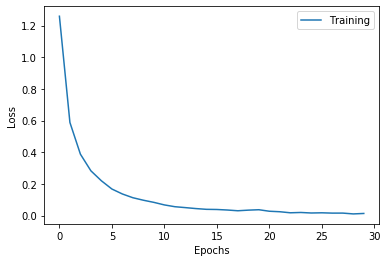

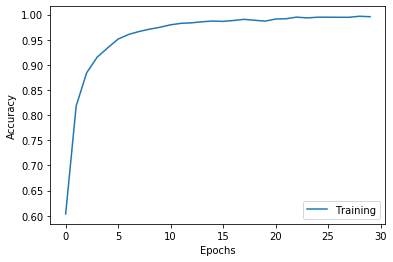

In [37]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.legend(['Training'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.legend(['Training'], loc='lower right')
plt.show()

In [38]:
y_pred_test = final_model.predict(x_test).argmax(axis=1)

In [39]:
y_pred_test = y_pred_test + first_letter

In [40]:
y_pred_test

array([22, 26, 25, ..., 22, 23, 20])

In [41]:
np.savetxt('Pranav_Kasela_846965_score2.txt', y_pred_test, fmt='%d')

# AutoEncoder

In [25]:
Encoded_shape = 150

input_image = Input(shape=(x_train.shape[1],))
encoded_1 = Dense(350, activation='relu')(input_image)
encoded_2 = Dense(Encoded_shape, activation='relu')(encoded_1)
decoded_1 = Dense(350, activation='relu')(encoded_2)
decoded_2 = Dense(784, activation='relu')(decoded_1)

#autoencoder
autoencoder = Model(input_image, decoded_2)
#encoder
encoder = Model(input_image, encoded_2)

#decoder
encoded_input = Input(shape=(Encoded_shape,))
decoder_layer_1 = autoencoder.layers[-2](encoded_input)
decoder_layer_2 = autoencoder.layers[-1](decoder_layer_1)
decoder = Model(encoded_input, decoder_layer_2)

In [26]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train,x_train, epochs=150,
                batch_size=512,validation_data=(x_val, x_val), callbacks=[early])

Train on 12600 samples, validate on 1400 samples
Epoch 1/150
12600/12600 [==============================] - 1s 45us/sample - loss: 0.0831 - val_loss: 0.0581
Epoch 2/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0435 - val_loss: 0.0314
Epoch 3/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0254 - val_loss: 0.0216
Epoch 4/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0187 - val_loss: 0.0171
Epoch 5/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0152 - val_loss: 0.0144
Epoch 6/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0136 - val_loss: 0.0130
Epoch 7/150
12600/12600 [==============================] - 0s 29us/sample - loss: 0.0119 - val_loss: 0.0121
Epoch 8/150
12600/12600 [==============================] - 0s 29us/sample - loss: 0.0111 - val_loss: 0.0110
Epoch 9/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.010

Epoch 76/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0044 - val_loss: 0.0047
Epoch 77/150
12600/12600 [==============================] - 0s 33us/sample - loss: 0.0043 - val_loss: 0.0047
Epoch 78/150
12600/12600 [==============================] - 0s 35us/sample - loss: 0.0043 - val_loss: 0.0047
Epoch 79/150
12600/12600 [==============================] - 0s 33us/sample - loss: 0.0043 - val_loss: 0.0047
Epoch 80/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0043 - val_loss: 0.0047
Epoch 81/150
12600/12600 [==============================] - 0s 29us/sample - loss: 0.0042 - val_loss: 0.0047
Epoch 82/150
12600/12600 [==============================] - 0s 29us/sample - loss: 0.0042 - val_loss: 0.0047
Epoch 83/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0042 - val_loss: 0.0048
Epoch 84/150
12600/12600 [==============================] - 0s 28us/sample - loss: 0.0042 - val_loss: 0.0046
Epoch 85/150
12600/

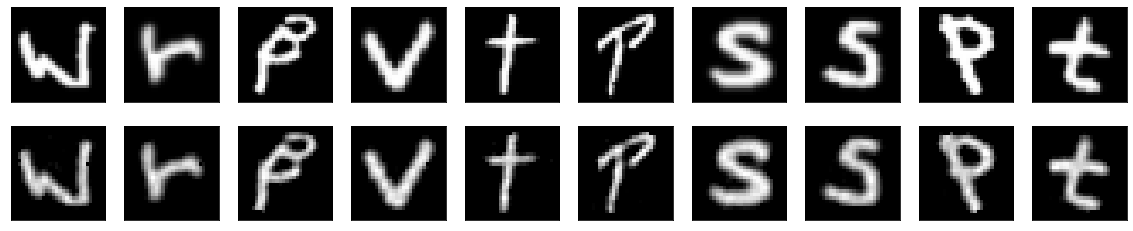

In [27]:
encoded_imgs = encoder.predict(x_val)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

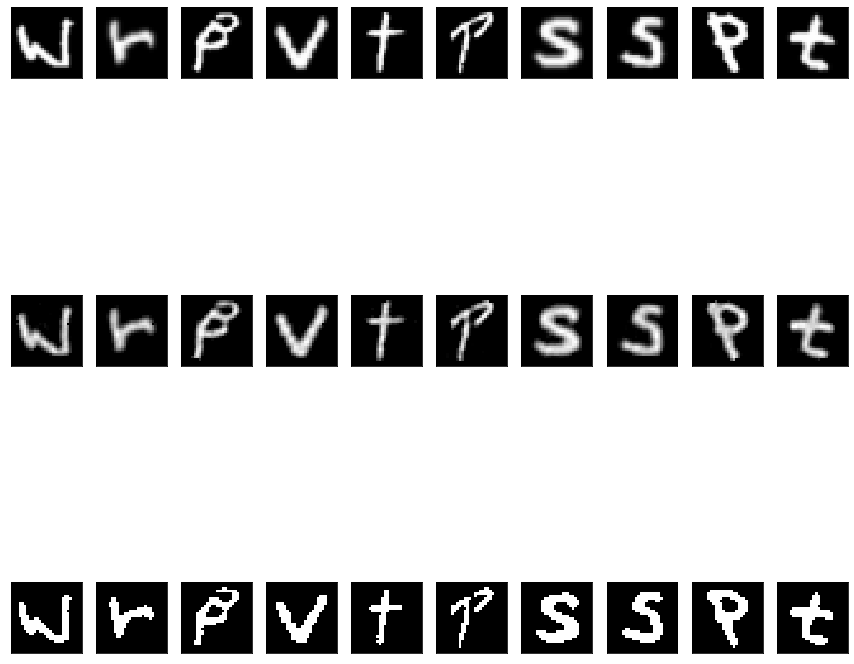

In [49]:
#one could apply also binarization for a better output image (atleast for the human eye)
plt.figure(figsize=(15,15))
for i in range(n):
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(binarize(decoded_imgs[i].reshape(28, 28), 0.5))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [28]:
layer1 = Dense(256, activation = 'relu')(encoded_2)
layer1 = Dropout(0.2)(layer1)
layer2 = Dense(256, activation='sigmoid')(layer1)
layer2 = Dropout(0.2)(layer2)
#layer2 = Dense(64, activation='relu')(layer2)
output = Dense(n_classes, activation='softmax')(layer2)
model_enc = Model(input_image, output)
model_enc.layers[0].trainable=False
model_enc.layers[1].trainable=False
model_enc.layers[2].trainable=False

model_enc.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [29]:
history = model_enc.fit(x_train, y_train_cat, validation_data=(x_val, y_val_cat),
                        batch_size=512, epochs=100, callbacks=[lr_decay])

Train on 12600 samples, validate on 1400 samples
Epoch 1/100
12600/12600 [==============================] - 1s 74us/sample - loss: 2.4408 - acc: 0.2098 - val_loss: 1.5542 - val_acc: 0.5243
Epoch 2/100
12600/12600 [==============================] - 1s 42us/sample - loss: 1.2834 - acc: 0.5682 - val_loss: 0.9554 - val_acc: 0.6971
Epoch 3/100
12600/12600 [==============================] - 1s 41us/sample - loss: 0.9465 - acc: 0.6867 - val_loss: 0.7521 - val_acc: 0.7586
Epoch 4/100
12600/12600 [==============================] - 1s 40us/sample - loss: 0.8027 - acc: 0.7413 - val_loss: 0.6768 - val_acc: 0.7843
Epoch 5/100
12600/12600 [==============================] - 1s 41us/sample - loss: 0.7124 - acc: 0.7712 - val_loss: 0.6198 - val_acc: 0.8007
Epoch 6/100
12600/12600 [==============================] - 0s 30us/sample - loss: 0.6563 - acc: 0.7849 - val_loss: 0.5468 - val_acc: 0.8164
Epoch 7/100
12600/12600 [==============================] - 0s 37us/sample - loss: 0.6321 - acc: 0.7957 - val_lo

12600/12600 [==============================] - 1s 41us/sample - loss: 0.2186 - acc: 0.9279 - val_loss: 0.2516 - val_acc: 0.9264
Epoch 54/100
12600/12600 [==============================] - 0s 39us/sample - loss: 0.2186 - acc: 0.9275 - val_loss: 0.2642 - val_acc: 0.9179
Epoch 55/100
12600/12600 [==============================] - 1s 41us/sample - loss: 0.2226 - acc: 0.9289 - val_loss: 0.2534 - val_acc: 0.9236
Epoch 56/100
10240/12600 [=======================>......] - ETA: 0s - loss: 0.2046 - acc: 0.9331
Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0026214396581053737.
12600/12600 [==============================] - 0s 30us/sample - loss: 0.2088 - acc: 0.9310 - val_loss: 0.2549 - val_acc: 0.9243
Epoch 57/100
12600/12600 [==============================] - 0s 39us/sample - loss: 0.2091 - acc: 0.9320 - val_loss: 0.2529 - val_acc: 0.9243
Epoch 58/100
12600/12600 [==============================] - 1s 40us/sample - loss: 0.2064 - acc: 0.9338 - val_loss: 0.2578 - val_acc: 0.9214
Epo

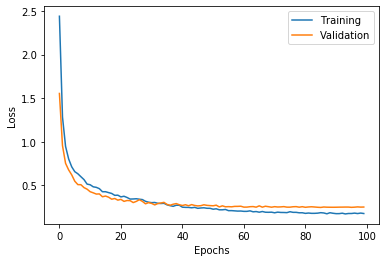

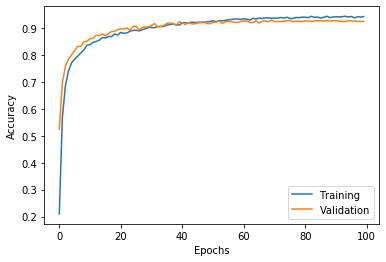

In [30]:
plot_history(history)

In [31]:
print(classification_report(y_val, model_enc.predict(x_val).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       136
           1       0.88      0.96      0.92       129
           2       0.90      0.90      0.90       124
           3       0.99      0.96      0.97       137
           4       0.94      0.89      0.92       121
           5       0.89      0.94      0.91       134
           6       0.90      0.87      0.88       128
           7       0.92      0.95      0.93       116
           8       0.96      0.92      0.94       146
           9       0.91      0.88      0.90       146
          10       0.92      0.96      0.94        83

    accuracy                           0.93      1400
   macro avg       0.92      0.93      0.93      1400
weighted avg       0.93      0.93      0.92      1400



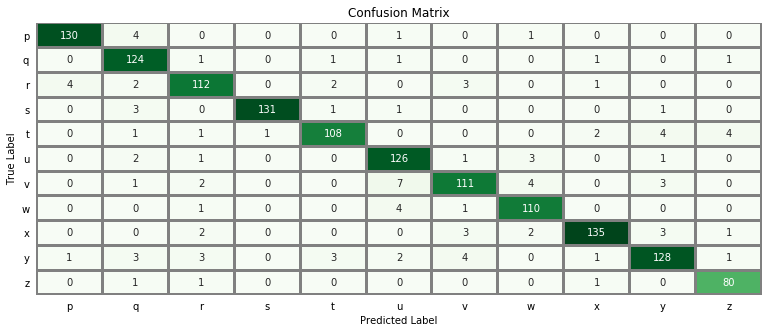

In [32]:
index = ['p','q','r','s','t','u','v','w','x','y','z']

plt.figure(figsize = (13,5))
cf_matrix = confusion_matrix(y_val, model_enc.predict(x_val).argmax(axis=1))
ax = sns.heatmap(cf_matrix, xticklabels=index, yticklabels=index, cmap='Greens',
                 cbar=False, annot=True, fmt='d', linewidths=2, linecolor='gray')
ax.tick_params(left=False, bottom=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

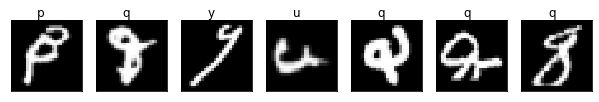

In [119]:
image_index = [2, 28, 46, 47, 69, 132, 166] #few letter I found manually
plt.figure(figsize=(15,15))
import string
d={}
for i, letter in enumerate(string.ascii_lowercase):
    d[i+1] = letter

for i, index in enumerate(image_index):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[index].reshape(28, 28))
    plt.text(10, -2, d[y_val[index]+first_letter],fontsize=12)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)